<a href="https://colab.research.google.com/github/vtroyv/generative-adversarial-networks/blob/main/mnistGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
print(torch.__version__)
print("GPU Available: ", torch.cuda.is_available())
if torch.cuda.is_available():
  device= torch.device("cuda:0")
else:
  device="cpu"
print(device)

# If you want to save the model to your personal google drive or transfer files you need to mount google drive
from google.colab import drive
drive.mount('/content/drive/')

2.6.0+cu124
GPU Available:  True
cuda:0
Mounted at /content/drive/


In [ ]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define a function to create out generator
def make_generator_network(input_size=20, num_hidden_layers=1, num_hidden_units=100, num_output_units=784):
  model = nn.Sequential()
  for i in range(num_hidden_layers):
    model.add_module(f'fc_g{i}', nn.Linear(input_size, num_hidden_units))
    model.add_module(f'relu_g{i}', nn.LeakyReLU())
    input_size = num_hidden_units
  model.add_module(f'fc_g{num_hidden_layers}', nn.Linear(input_size, num_output_units))
  model.add_module('tanh_g', nn.Tanh())
  return model

#Define a function for the descriminator
def make_descriminator_network(input_size, num_hidden_layers=1, num_hidden_units=100, num_output_units =1):
  model = nn.Sequential()
  for i in range(num_hidden_layers):
    model.add_module(f'fc_d{i}', nn.Linear(input_size, num_hidden_units, bias=False))
    model.add_module(f'relu_d{i}', nn.LeakyReLU())
    model.add_module(f'dropout', nn.Dropout(p=0.5))
    input_size= num_hidden_units
  model.add_module(f'fc_d{num_hidden_layers}', nn.Linear(input_size, num_output_units))
  model.add_module('sigmoid', nn.Sigmoid())
  return model



#Next we initialize each of the networks
image_size= (28,28)
z_size = 20
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers =1
disc_hidden_size=100
torch.manual_seed(1)

gen_model = make_generator_network(input_size=z_size, num_hidden_layers=gen_hidden_layers, num_hidden_units=gen_hidden_size, num_output_units=np.prod(image_size))
print(gen_model)

disc_model = make_descriminator_network(input_size=np.prod(image_size), num_hidden_layers=disc_hidden_layers, num_hidden_units=disc_hidden_size)
print(disc_model)




Sequential(
  (fc_g0): Linear(in_features=20, out_features=100, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g1): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)
Sequential(
  (fc_d0): Linear(in_features=784, out_features=100, bias=False)
  (relu_d0): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_d1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
import torchvision
from torchvision import transforms
image_path='./'
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5)) ])

mnist_dataset= torchvision.datasets.MNIST(root=image_path, train=True, transform = transform, download=True)

example,label = next(iter(mnist_dataset))
print(f'Min: {example.min()} Max: {example.max()}')
print(example.shape)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.83MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.09MB/s]

Min: -1.0 Max: 1.0
torch.Size([1, 28, 28])


In [ ]:
# Create random vector z based on desired distribution

def create_noise(batch_size, z_size, mode_z):
  if mode_z =='uniform':
    input_z = torch.rand(batch_size, z_size) *2 -1 #why do we combine it like this?
  elif mode_z == 'normal':
    input_z = torch.randn(batch_size, z_size)
  return input_z

In [ ]:
# Run through and get a batch of probabilities for the fake images and real images

from torch.utils.data import DataLoader
batch_size = 32
dataloader = DataLoader(mnist_dataset, batch_size, shuffle=False)
input_real, label = next(iter(dataloader))
input_real = input_real.view(batch_size, -1)
torch.manual_seed(1)

mode_z ='uniform'
input_z = create_noise(batch_size, z_size, mode_z)
print('input-z -- shape:', input_z.shape)
print('input-real -- shape:', input_real.shape)

g_output = gen_model(input_z)
print('Output of G -- shape:', g_output.shape)

d_proba_real = disc_model(input_real)
d_proba_fake = disc_model(g_output)
print('Probability of real images -- shape:', d_proba_real.shape)
print('Probability of fake images -- shape:', d_proba_fake.shape)




input-z -- shape: torch.Size([32, 20])
input-real -- shape: torch.Size([32, 784])
Output of G -- shape: torch.Size([32, 784])
Probability of real images -- shape: torch.Size([32, 1])
Probability of fake images -- shape: torch.Size([32, 1])


In [ ]:
# Create loss and generate ground truth labels

loss_fn = nn.BCELoss()

# loss for generator
g_labels_real = torch.ones_like(d_proba_fake)
g_loss = loss_fn(d_proba_fake, g_labels_real)
print(f'Generator Loss: {g_loss:.4f}')

# Loss for discriminator
d_labels_real = torch.ones_like(d_proba_real)
d_labels_fake = torch.zeros_like(d_proba_fake)
d_loss_real = loss_fn(d_proba_real, d_labels_real)
d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

print(f'Discriminator losses: Real {d_loss_real:.4f} Fake {d_loss_fake:.4f}')


Generator Loss: 0.6983
Discriminator losses: Real 0.7479 Fake 0.6885


In [ ]:
# Now we set up teh dataloader for the real dataset, the generator, discriminator and separate adam optimizer

batch_size = 64
torch.manual_seed(1)
np.random.seed(1)

mnist_dl =DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

first_images, first_labels = next(iter(mnist_dl))
print(f'The first image is {first_images[0].shape}')
print(f"THe first label is {first_labels[0]}")

gen_model = make_generator_network(
    input_size=z_size,
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units= gen_hidden_size,
    num_output_units=np.prod(image_size)
).to(device)

disc_model = make_descriminator_network(
    input_size=np.prod(image_size),
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size
).to(device)


loss_fn = nn.BCELoss()
g_optimizer= torch.optim.Adam(gen_model.parameters())
d_optimizer=torch.optim.Adam(disc_model.parameters())



The first image is torch.Size([1, 28, 28])
THe first label is 4


In [ ]:
#write two training utility functions for the  discriminator and generator using two separate adam optimizers

# Train the discriminator
def d_train(x):
  disc_model.zero_grad()
  # Train the discriminator with a real batch
  batch_size = x.size(0)
  x = x.view(batch_size, -1).to(device)
  d_labels_real = torch.ones(batch_size, 1, device=device)
  d_proba_real = disc_model(x)
  d_loss_real = loss_fn(d_proba_real, d_labels_real)

  # Train discriminator on a fake batch

  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_output = gen_model(input_z)
  d_proba_fake = disc_model(g_output)
  d_labels_fake = torch.zeros(batch_size,1,device=device)
  d_loss_fake =loss_fn(d_proba_fake, d_labels_fake)

  # Gradient backprop & optimize only D's parameters
  d_loss = d_loss_real + d_loss_fake
  d_loss.backward()
  d_optimizer.step()
  return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

  #Train the generator

def g_train(x):
  gen_model.zero_grad()
  batch_size = x.size(0)
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_labels_real = torch.ones(batch_size,1, device=device)

  g_output= gen_model(input_z)
  d_proba_fake = disc_model(g_output)
  g_loss = loss_fn(d_proba_fake, g_labels_real)
  # gradient backprop & optimize ONLY G's parameters
  g_loss.backward()
  g_optimizer.step()
  return g_loss.data.item()







In [ ]:
# Now we will start alternatinig traing of geneator and discriminator over 100 epochs
# for each epoch we will record the loss for the generator, discriminator, aswell as loss for real & fake data respectively.
# We will also generatre some examples from a the latent vector z from the current generator model via create_samples() and store these synthnesized images in a list

fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
  g_output = g_model(input_z)
  images =torch.reshape(g_output, (batch_size, *image_size))
  return (images+1)/2.0

epoch_samples = []
all_d_losses = []
all_g_losses = []
all_d_real = []
all_d_fake = []
num_epochs = 100

for epoch in range(1, num_epochs+1):
  d_losses, g_losses = [],[]

  d_vals_real, d_vals_fake = [],[]

  for i, (x,_) in enumerate(mnist_dl):
    d_loss, d_proba_real, d_proba_fake= d_train(x)
    d_losses.append(d_loss)
    g_losses.append(g_train(x))
    d_vals_real.append(d_proba_real.mean().cpu())
    d_vals_fake.append(d_proba_fake.mean().cpu())

  all_d_losses.append(torch.tensor(d_losses).mean())
  all_g_losses.append(torch.tensor(g_losses).mean())
  all_d_real.append(torch.tensor(d_vals_real).mean())
  all_d_fake.append(torch.tensor(d_vals_fake).mean())
  print(f'Epoch {epoch:03d} | Avg Losses >>'
  f'G/D {all_g_losses[-1]:.4f}/{all_d_losses[-1]:4f}'
  f' [D-Real: {all_d_real[-1]:.4f}'
  f' D-Fake: {all_d_fake[-1]:.4f}]')
  epoch_samples.append(create_samples(gen_model, fixed_z).detach().cpu().numpy())



Epoch 001 | Avg Losses >>G/D 0.9020/0.880472 [D-Real: 0.8317 D-Fake: 0.4781]
Epoch 002 | Avg Losses >>G/D 1.0007/1.092743 [D-Real: 0.6307 D-Fake: 0.4228]
Epoch 003 | Avg Losses >>G/D 0.9675/1.160848 [D-Real: 0.5989 D-Fake: 0.4183]
Epoch 004 | Avg Losses >>G/D 0.9796/1.194591 [D-Real: 0.5832 D-Fake: 0.4180]
Epoch 005 | Avg Losses >>G/D 0.9081/1.233730 [D-Real: 0.5686 D-Fake: 0.4323]
Epoch 006 | Avg Losses >>G/D 0.9623/1.215204 [D-Real: 0.5723 D-Fake: 0.4205]
Epoch 007 | Avg Losses >>G/D 0.8827/1.266847 [D-Real: 0.5527 D-Fake: 0.4431]
Epoch 008 | Avg Losses >>G/D 1.0358/1.180521 [D-Real: 0.5917 D-Fake: 0.4089]
Epoch 009 | Avg Losses >>G/D 1.1428/1.095757 [D-Real: 0.6252 D-Fake: 0.3808]
Epoch 010 | Avg Losses >>G/D 0.9542/1.197297 [D-Real: 0.5876 D-Fake: 0.4184]
Epoch 011 | Avg Losses >>G/D 0.9545/1.205703 [D-Real: 0.5836 D-Fake: 0.4190]
Epoch 012 | Avg Losses >>G/D 0.9768/1.206133 [D-Real: 0.5817 D-Fake: 0.4169]
Epoch 013 | Avg Losses >>G/D 0.9669/1.204329 [D-Real: 0.5821 D-Fake: 0.4180]

In [ ]:
# in this cel lets plot the convergence of probabilities as well as some examples
# of the synthesized images

In [ ]:
# Now we will attempt to improve the our previous results from GAN via an implementation following the
# CGAN architecture. The main differences will layers using transposed Convolution, aswell as applying BatchNorm to standardize features
# and enable smoother training

# recreate the make_generator_network funciton
def make_generator_network(input_size, n_filters):
  model = nn.Sequential(
      nn.ConvTranspose2d(input_size, n_filters*4, 4,1,0, bias=False),
      nn.BatchNorm2d(n_filters*4),
      nn.LeakyReLU(0.2),
      nn.ConvTranspose2d(n_filters*4, n_filters*2, 3,2,1, bias=False),
      nn.BatchNorm2d(n_filters*2),
      nn.LeakyReLU(0.2),
      nn.ConvTranspose2d(n_filters*2, n_filters, 4,2,1, bias=False),
      nn.BatchNorm2d(n_filters),
      nn.LeakyReLU(0.2),
      nn.ConvTranspose2d(n_filters, 1, 4,2,1, bias=False),
      nn.Tanh()
  )
  return model


class Discriminator(nn.Module):
  def __init__(self, n_filters):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(1, n_filters, 4,2,1, bias=False),
        nn.LeakyReLU(0.2),
        nn.Conv2d(n_filters, n_filters*2, 4,2,1, bias=False),
        nn.BatchNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),
        nn.Conv2d(n_filters*2, n_filters*4, 3,2,1, bias=False),
        nn.BatchNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),
        nn.Conv2d(n_filters*4, 1, 4,1,0, bias=False),
        nn.Sigmoid()
    )

  def forward(self,input):
    output = self.network(input)
    return output.view(-1,1).squeeze(0)




In [ ]:
z_size = 100
image_size = (28,28)
n_filters=32

# Lets create the gen_model and disc_model and see it's architecture
gen_model= make_generator_network(z_size, n_filters).to(device)
print(gen_model)

disc_model = Discriminator(n_filters).to(device)
print(disc_model)


Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)
Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

In [ ]:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.003)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.002)

In [ ]:
# now lets rewrite the create_noise function so it outputs a tensor of four dimensions instead of a vector

def create_noise(batch_size, z_size, mode_z):
  if mode_z == 'uniform':
    input_z = torch.rand(batch_size, z_size,1,1)*1 -1
  elif mode_z == 'normal':
    input_z = torch.randn(batch_size, z_size,1,1)
  return input_z


# now we rewrite a d_train() funciton for training the discriminator it doesn't need to reshape the input image

def d_train(x):
  disc_model.zero_grad()

  # train discriminator with a real batch
  batch_size = x.size(0)
  x = x.to(device)
  d_labels_real = torch.ones(batch_size,1,device=device)
  d_proba_real = disc_model(x)
  d_loss_real = loss_fn(d_proba_real, d_labels_real)

  # Train discriminator on a fake batch
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_output = gen_model(input_z)
  d_proba_fake = disc_model(g_output)
  d_labels_fake= torch.zeros(batch_size,1,device=device)
  d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

  # gradient backprop & optimize only D's parameters
  d_loss = d_loss_real + d_loss_fake
  d_loss.backward()
  d_optimizer.step()
  return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()


In [ ]:
# now we alternate between the training of the generator and the discriminator for 100 epochs
# we will also generate some samples aswell

fixed_z = create_noise(batch_size, z_size, mode_z).to(device)
epoch_samples= []
torch.manual_seed(1)
epoch_samples = []
all_d_losses = []
all_g_losses = []
all_d_real = []
all_d_fake = []
num_epochs = 100

def create_samples(g_model, input_z):
  g_output = g_model(input_z)
  images =torch.reshape(g_output, (batch_size, *image_size))
  return (images+1)/2.0

for epoch in range(1, num_epochs+1):
  d_losses, g_losses = [],[]
  gen_model.train()

  for i, (x,_) in enumerate(mnist_dl):
    d_loss, d_proba_real, d_proba_fake = d_train(x)
    d_losses.append(d_loss)
    g_losses.append(g_train(x))

  print(f'Epoch {epoch:03d} | Avg Losses >>'
        f' G/D {torch.FloatTensor(g_losses).mean():.4f}'
        f'/{torch.FloatTensor(d_losses).mean():.4f}')

  gen_model.eval()
  epoch_samples.append(create_samples(gen_model, fixed_z).detach().cpu().numpy())



Epoch 001 | Avg Losses >> G/D 8.3308/0.0462
Epoch 002 | Avg Losses >> G/D 9.3807/0.0484
Epoch 003 | Avg Losses >> G/D 9.0330/0.0287
Epoch 004 | Avg Losses >> G/D 10.3196/0.0006
Epoch 005 | Avg Losses >> G/D 37.8093/0.0089
Epoch 006 | Avg Losses >> G/D 55.3489/0.0000
Epoch 007 | Avg Losses >> G/D 55.3483/0.0000
Epoch 008 | Avg Losses >> G/D 55.3485/0.0000
Epoch 009 | Avg Losses >> G/D 55.3483/0.0000
Epoch 010 | Avg Losses >> G/D 55.3485/0.0000
Epoch 011 | Avg Losses >> G/D 55.3484/0.0000
Epoch 012 | Avg Losses >> G/D 55.3487/0.0000
Epoch 013 | Avg Losses >> G/D 55.3483/0.0000
Epoch 014 | Avg Losses >> G/D 55.3487/0.0000
Epoch 015 | Avg Losses >> G/D 55.3488/0.0000
Epoch 016 | Avg Losses >> G/D 55.3488/0.0000
Epoch 017 | Avg Losses >> G/D 55.3481/0.0000
Epoch 018 | Avg Losses >> G/D 55.3486/0.0000
Epoch 019 | Avg Losses >> G/D 55.3486/0.0000
Epoch 020 | Avg Losses >> G/D 55.3482/0.0000
Epoch 021 | Avg Losses >> G/D 55.3486/0.0000
Epoch 022 | Avg Losses >> G/D 55.3485/0.0000
Epoch 023 | A

NameError: name 'epoch_samples' is not defined

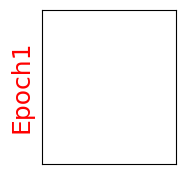

In [ ]:
# now lets visualize the saved examples
from matplotlib import pyplot as plt
selected_epochs = [1,2,4,10,50,100]

fig = plt.figure(figsize=(10,14))
for i,e in enumerate(selected_epochs):
  for j in range(5):
    ax = fig.add_subplot(6,5,i*5+j+1)
    ax.set_xticks([])
    ax.set_yticks([])

    if j ==0:
      ax.text(-0.06, 0.5, f'Epoch{e}', rotation=90, size=18, color='red', horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)

    image=epoch_samples[e-1][j]
    ax.imshow(image, cmap='gray')
plt.show()

